In [1]:
import os
import cv2
import pandas
import numpy as np
from tqdm import tqdm
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
from random import choice, choices, shuffle

import torch
import torchvision
import torch.nn as nn 
from torch.utils.data import DataLoader, Dataset

from torchsummary import summary
import torchvision.models as models
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from random import randint
import albumentations as A
from PIL import Image


In [19]:
%load_ext autoreload
%autoreload 2
# from image_utils import plot_img, plot_imgs

SyntaxError: unexpected EOF while parsing (<ipython-input-19-42be17a65e92>, line 4)

In [2]:
def plot_img(img, size=(7,7), title=""):
    if isinstance(img, str):
        img = load_img(img)
    cmap = "gray" if len(img.shape) == 2 else None
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    
def plot_imgs(imgs, cols=5, size=7, title=""):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if isinstance(img, str):
            img = load_img(img, size=300)
        cmap="gray" if len(img.shape) == 2 else None
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    
def recover_img(l_chanel, ab_chanel):
    l_chanel = l_chanel*255
    ab_chanel = ab_chanel*128 + 128
    img = np.concatenate([l_chanel, ab_chanel], axis=-1)
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img
    
def toTensor(np_array, axis=(2,0,1)):
    return torch.tensor(np_array).permute(axis)

def toNumpy(tensor, axis=(1,2,0)):
    return tensor.detach().cpu().permute(axis).numpy()

## Define Dataset / data_generator

In [3]:
class MaskDataset(Dataset):
    def __init__(self, img_fns, mask_dir, transforms=None):
        self.img_fns = img_fns
        self.transforms = transforms
        self.mask_dir = mask_dir
        
    def __getitem__(self, idx):
        img_path = self.img_fns[idx]
        img_name = img_path.split("/")[-1].split(".")[0]
        mask_fn = f"{self.mask_dir}/{img_name}.png"

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_fn)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        if self.transforms:
            sample = {
                "image": img,
                "mask": mask
            }
            sample = self.transforms(**sample)
            img = sample["image"]
            mask = sample["mask"]

        # to Tensor
        img = img/255.0
        mask = np.expand_dims(mask, axis=-1)/255.0
        mask = toTensor(mask).float()
        img = toTensor(img).float()
        return img, mask
            
    def __len__(self):
        return len(self.img_fns)

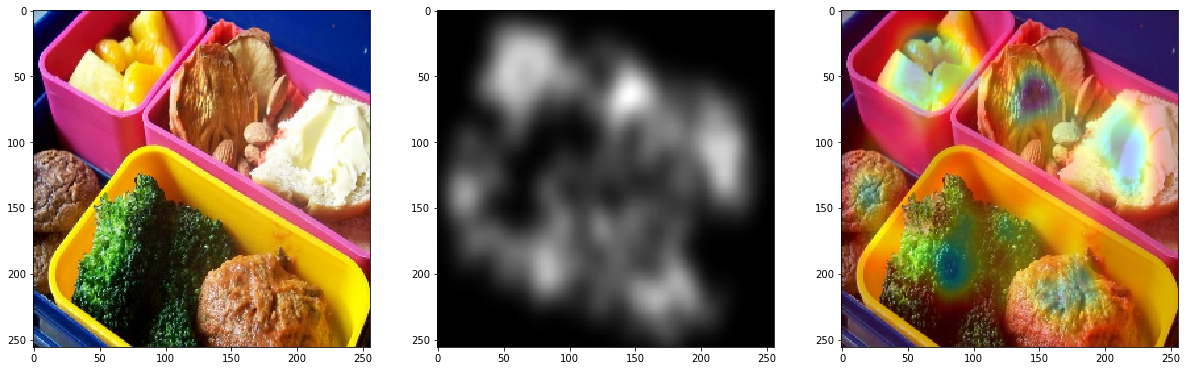

In [4]:
img_fns = glob("./images/images/train/*.jpg")
mask_dir = "./maps/"

train_transform = A.Compose([
    A.Resize(width=256,height=256, p=1),
    A.RandomSizedCrop([240,256], height=256, width=256, p=0.4),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(-10,10), p=0.6),
])

train_dataset = MaskDataset(img_fns, mask_dir, train_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)

# Test dataset
img, mask = next(iter(train_dataset))
img = toNumpy(img)
mask = toNumpy(mask)[:,:,0]
img = (img*255.0).astype(np.uint8)
mask = (mask*255.0).astype(np.uint8)

heatmap_img = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
combine_img = cv2.addWeighted(img, 0.7, heatmap_img, 0.3, 0)
plot_imgs([img, mask, combine_img])

##  Define model architecture

In [5]:
def Deconv(n_input, n_output, k_size=4, stride=2, padding=1):
    Tconv = nn.ConvTranspose2d(
        n_input, n_output,
        kernel_size=k_size,
        stride=stride, padding=padding,
        bias=False)
    block = [
        Tconv,
        nn.BatchNorm2d(n_output),
        nn.LeakyReLU(inplace=True),
    ]
    return nn.Sequential(*block)
        

def Conv(n_input, n_output, k_size=4, stride=2, padding=0, bn=False, dropout=0):
    conv = nn.Conv2d(
        n_input, n_output,
        kernel_size=k_size,
        stride=stride,
        padding=padding, bias=False)
    block = [
        conv,
        nn.BatchNorm2d(n_output),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(dropout)
    ]
    return nn.Sequential(*block)

class Unet(nn.Module):
    def __init__(self, resnet):
        super().__init__()
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        # get some layer from resnet to make skip connection
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # convolution layer, use to reduce the number of channel => reduce weight number
        self.conv_5 = Conv(2048, 512, 1, 1, 0)
        self.conv_4 = Conv(1536, 512, 1, 1, 0)
        self.conv_3 = Conv(768, 256, 1, 1, 0)
        self.conv_2 = Conv(384, 128, 1, 1, 0)
        self.conv_1 = Conv(128, 64, 1, 1, 0)
        self.conv_0 = Conv(32, 1, 3, 1, 1)
        
        # deconvolution layer
        self.deconv4 = Deconv(512, 512, 4, 2, 1)
        self.deconv3 = Deconv(512, 256, 4, 2, 1)
        self.deconv2 = Deconv(256, 128, 4, 2, 1)
        self.deconv1 = Deconv(128, 64, 4, 2, 1)
        self.deconv0 = Deconv(64, 32, 4, 2, 1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        skip_1 = x
        
        x = self.maxpool(x)
        x = self.layer1(x)
        skip_2 = x

        x = self.layer2(x)
        skip_3 = x
        x = self.layer3(x)
        skip_4 = x
        
        x5 = self.layer4(x)
        x5 = self.conv_5(x5)
        
        x4 = self.deconv4(x5)
        x4 = torch.cat([x4, skip_4], dim=1)
        x4 = self.conv_4(x4)
        
        x3 = self.deconv3(x4)
        x3 = torch.cat([x3, skip_3], dim=1)
        x3 = self.conv_3(x3)
        
        x2 = self.deconv2(x3)
        x2 = torch.cat([x2, skip_2], dim=1)
        x2 = self.conv_2(x2)
        
        x1 = self.deconv1(x2)
        x1 = torch.cat([x1, skip_1], dim=1)
        x1 = self.conv_1(x1)
        
        x0 = self.deconv0(x1)
        x0 = self.conv_0(x0)
        
        x0 = self.sigmoid(x0)
        return x0

In [6]:
device = torch.device("cuda")
resnet50 = models.resnet50(pretrained=True)

model = Unet(resnet50)
model.to(device)

## Test model
img = torch.ones((8,3,256,256)).to(device)
mask = model(img)
print(mask.shape)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Administrator/.cache\torch\checkpoints\resnet50-19c8e357.pth



torch.Size([8, 1, 256, 256])


### Freeze pre-trained layer in model 

In [7]:
for i, child in enumerate(model.children()):
    if i <= 7:
        for param in child.parameters():
            param.requires_grad = False
            


## Train model

In [8]:
train_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.Adam(train_params, lr=0.001, betas=(0.9, 0.99))

epochs = 5
model.train()
saved_dir = "model"
os.makedirs(saved_dir, exist_ok=True)
loss_function = nn.MSELoss(reduce="mean")

for epoch in range(epochs):
    for imgs, masks in tqdm(train_loader):
        imgs_gpu = imgs.to(device)
        outputs = model(imgs_gpu)
        masks = masks.to(device)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
    loss_value = loss.detach().cpu().numpy()
    print(f"epoch {epoch}, loss value: {loss_value}")
        

D:\Anaconda3\envs\quanap5\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
  0%|                                                                                 | 1/2500 [00:00<04:52,  8.55it/s]

epoch 0, loss value: 0.11706151068210602


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

epoch 1, loss value: 0.0526057705283165


  0%|                                                                                 | 1/2500 [00:00<04:17,  9.71it/s]

epoch 2, loss value: 0.02763191983103752


  0%|                                                                                 | 1/2500 [00:00<04:49,  8.62it/s]

epoch 3, loss value: 0.03892044723033905


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [05:07<00:00,  8.14it/s]

epoch 4, loss value: 0.026935916393995285


### Validate / Test model

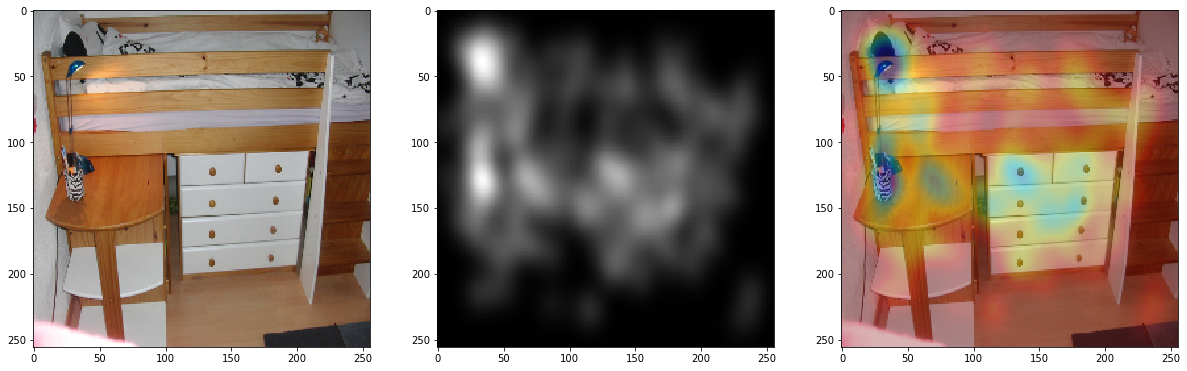

In [32]:
img_fns = glob("./images/images/val/*.jpg")
mask_dir = "./maps/"

val_transform = A.Compose([
    A.Resize(width=256,height=256, p=1),
    A.HorizontalFlip(p=0.5),
])

val_dataset = MaskDataset(img_fns, mask_dir, val_transform)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, drop_last=True)

# Test dataset
img, mask = next(iter(val_dataset))
img = toNumpy(img)
mask = toNumpy(mask)[:,:,0]
img = (img*255.0).astype(np.uint8)
mask = (mask*255.0).astype(np.uint8)

heatmap_img = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
combine_img = cv2.addWeighted(img, 0.7, heatmap_img, 0.3, 0)
plot_imgs([img, mask, combine_img])

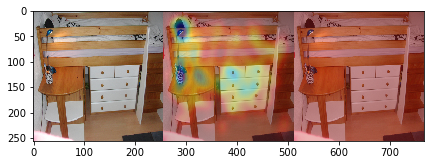

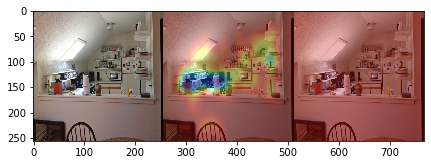

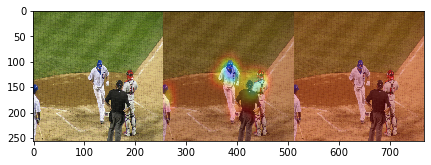

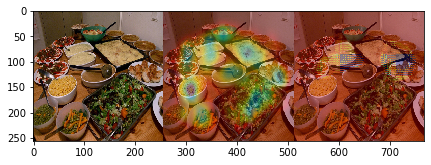

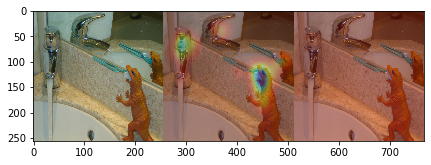

In [33]:
model.eval()

for k, (imgs, mask_targets) in enumerate(val_loader):
    imgs_gpu = imgs.to(device)
    mask_outputs = model(imgs_gpu)
    mask_outputs = toNumpy(mask_outputs, axis=(0,2,3,1))
    imgs = toNumpy(imgs, axis=(0,2,3,1))
    mask_targets = toNumpy(mask_targets, axis=(0,2,3,1))
    
    for i, img in enumerate(imgs):
        img = (img*255.0).astype(np.uint8)
        mask_output = (mask_outputs[i]*255.0).astype(np.uint8)
        mask_target = (mask_targets[i]*255.0).astype(np.uint8)
        heatmap_label = cv2.applyColorMap(mask_target, cv2.COLORMAP_JET)
        heatmap_pred = cv2.applyColorMap(mask_output, cv2.COLORMAP_JET)
        
        origin_img = cv2.addWeighted(img, 0.7, heatmap_label, 0.3, 0)
        predict_img =  cv2.addWeighted(img, 0.7, heatmap_pred, 0.3, 0)
        result = np.concatenate((img,origin_img, predict_img),axis=1)
        plot_img(result)
    
    break